# Data Re-Uploading QCNN_TTN

This demo uses 4-qubit Quantum Convolutional Neural Network (QCNN) to see how pre-training the quantum embedding can be helpful for training a parameterized QML circuits for classfication tasks.

If you are interested in detailed analysis of pre-training on 8-qubit device, check out "/Result/earlystop 10 experiments/" folder.

If you are interested in the details about the QCNN used in this demo, check out https://arxiv.org/pdf/2108.00661.pdf.


In [1]:
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/home/tak/Github/QEmbedding/')
import torch
from torch import nn
import data
import embedding

2024-04-01 22:59:30.327792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


IBMQ Fake provider

In [2]:
import pennylane as qml
from pennylane import numpy as np

# Part1: Noisy Model1 & Model 2

Load the dataset for Model1 and Model2

In [3]:
dev = qml.device('default.qubit', wires=4)
feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

2024-04-01 22:59:33.055188: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Part1: Pre-training the embedding

In [4]:
steps = 1000
learning_rate = 0.01
batch_size = 128
ansatz = 'SU4'

def data_reuploading_ansatz(params): #8 params
    for i in range(4):
        qml.RY(params[i], wires=i)
    for i in range(3):
        qml.IsingZZ(params[i+4], wires=[i,i+1])
    qml.IsingZZ(params[7], wires=[3,0])

def data_reuploading_embedding(num_layers, params, x):
    for l in range(num_layers):
        data_reuploading_ansatz(params[8 * l : 8 * (l + 1)])
        embedding.Noisy_Four_QuantumEmbedding1(x)


@qml.qnode(dev)
def data_reuploading_QCNN_classifier(num_layers, params, x):
    data_reuploading_embedding(num_layers, params, x)
    embedding.QCNN_four(params[8 * num_layers: 8 * num_layers + 30], ansatz)
    return qml.expval(qml.PauliZ(2))


def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)


def cost(weights, X_batch, Y_batch, num_layers):
    preds = [data_reuploading_QCNN_classifier(num_layers, weights, x) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, num_layers):

    if ansatz == 'SU4':
        num_weights = (num_layers * 8) + 30
    elif ansatz == 'TTN':
        num_weights = (num_layers * 8) + 4

    weights = np.random.random(num_weights, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, num_layers),
                                                     weights)
        loss_history.append(cost_new)
        if it % 200 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

In [6]:

Loss_histories_L1, weights_L1, Loss_histories_L2, weights_L2, Loss_histories_L3, weights_L3 = [], [], [], [], [], []
for i in range(5):
    loss_L1, weight_L1 = circuit_training(X_train, Y_train, 1)
    loss_L2, weight_L2 = circuit_training(X_train, Y_train, 2)
    loss_L3, weight_L3 = circuit_training(X_train, Y_train, 3)

    Loss_histories_L1.append(loss_L1)
    Loss_histories_L2.append(loss_L2)
    Loss_histories_L3.append(loss_L3)

    weights_L1.append(weight_L1)
    weights_L2.append(weight_L2)
    weights_L3.append(weight_L3)

f = open('/home/tak/Github/QEmbedding/Other Experiments/data_reuploading/noiseless/Loss_and_weights.txt', 'a')
for i in range(5):
    f.write(f'Loss History L=1 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L1[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L1 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L1[i]))


for i in range(5):
    f.write(f'Loss History L=2 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L2[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L=2 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L2[i]))

for i in range(5):
    f.write(f'Loss History L=3 {i + 1}:')
    f.write('\n')
    f.write(str(Loss_histories_L3[i]))
    f.write('\n')
for i in range(5):
    f.write(f'Weights L=3 {i + 1}:')
    f.write('\n')
    f.write(str(weights_L3[i]))
f.close()



/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.504043396011034
iteration:  200  cost:  0.2878478294645107
iteration:  400  cost:  0.26990430691366557
iteration:  600  cost:  0.23459004107058382
iteration:  800  cost:  0.2383931940602779
iteration:  0  cost:  0.5061666285367339
iteration:  200  cost:  0.3922573698662707
iteration:  400  cost:  0.4028864454568903
iteration:  600  cost:  0.35607022658526877
iteration:  800  cost:  0.3149356241744572
iteration:  0  cost:  0.5189477626679112
iteration:  200  cost:  0.3599192846604731
iteration:  400  cost:  0.37230098207316326
iteration:  600  cost:  0.3028122830269683
iteration:  800  cost:  0.24503410152351207
iteration:  0  cost:  0.44831589785551734
iteration:  200  cost:  0.2657722885481958
iteration:  400  cost:  0.27745877554832665
iteration:  600  cost:  0.23047449176984686
iteration:  800  cost:  0.25781270372849263
iteration:  0  cost:  0.4877929879398151
iteration:  200  cost:  0.2966917916064929
iteration:  400  cost:  0.23095839980971083
iteration:  

# Part 4: Result 

Load the results

In [5]:
PATH_LH = 'Loss_fashion.txt'
PATH_w = 'Weights_fashion.txt'


def data_read(PATH):
  textfile = open(PATH, 'r')
  data = np.array([])
  for line in textfile:
    a = np.array([float(v) for v in line.strip().split(" ")])
    data = np.append(data, a)
  return data

Loss_history = data_read(PATH_LH).reshape(6,5,1000)
Weights = data_read(PATH_w)

Weights_L1 = Weights[0:38 * 5].reshape(5, 38)
Weights_L2 = Weights[38 * 5: 38 * 5 + 46 * 5].reshape(5, 46)
Weights_L3 = Weights[38* 5 + 46 * 5: 38 * 5 + 46 * 5 + 54 * 5].reshape(5, 54)

Loss_history_L1, Loss_history_L2, Loss_history_L3 = Loss_history[0], Loss_history[1], Loss_history[2]
Loss_histiry_without_NQE, Loss_history_PCA_NQE, Loss_history_NQE = Loss_history[3], Loss_history[4], Loss_history[5]

Loss_history_L1_mean, Loss_history_L1_std = Loss_history_L1.mean(axis=0), Loss_history_L1.std(axis=0)
Loss_history_L2_mean, Loss_history_L2_std = Loss_history_L2.mean(axis=0), Loss_history_L2.std(axis=0)
Loss_history_L3_mean, Loss_history_L3_std = Loss_history_L3.mean(axis=0), Loss_history_L3.std(axis=0)
Loss_history_PCA_NQE_mean, Loss_history_PCA_NQE_std = Loss_history_PCA_NQE.mean(axis=0), Loss_history_PCA_NQE.std(axis=0)
Loss_history_NQE_mean, Loss_history_NQE_std = Loss_history_NQE.mean(axis=0), Loss_history_NQE.std(axis=0)

Weights_L1_mean, Weigths_L1_std = Weights_L1.mean(axis=0), Weights_L1.std(axis=0)
Weights_L2_mean, Weigths_L2_std = Weights_L2.mean(axis=0), Weights_L2.std(axis=0)
Weights_L3_mean, Weigths_L3_std = Weights_L3.mean(axis=0), Weights_L3.std(axis=0)

Plot the results for Model 1,2,3

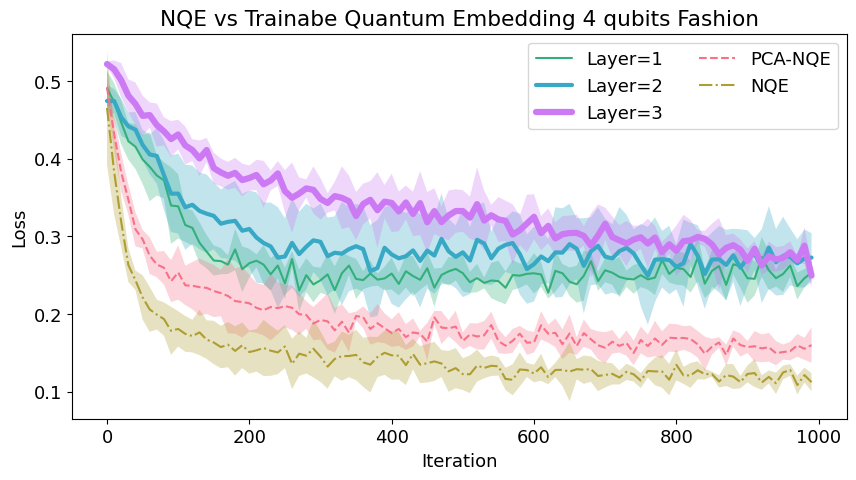

In [7]:
import seaborn as sns
#converged_NQES = (Loss_history_PCA_NQE_mean[800:1000].mean() + Loss_history_NQE_mean[800:1000].mean())/2
#LB_with_PCA_NQE = 0.5 * (1 - 0.8764684796333313)
#LB_with_NQE = 0.5 * (1 - 0.914618194103241)
n = 10
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams.update({'font.size': 13})
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 5)
with sns.axes_style("darkgrid"):
    #ax.plot(range(1000), np.ones(1000) * LB_with_PCA_NQE, linestyle='dashed', linewidth=3, label="Lower Bound PCA-NQE", c=clrs[0])
    #ax.plot(range(1000), np.ones(1000) * LB_with_NQE, linestyle='dashdot', linewidth=3, label="Lower Bound NQE", c=clrs[1])
    #ax.plot(range(1000), np.ones(1000) * converged_NQES, linestyle='dashed', linewidth=3, label="Converged NQE Losses", c=clrs[0])

    ax.plot(np.array(range(len(Loss_history_L1_mean[::n]))) * n, Loss_history_L1_mean[::n], linewidth=1.5, label="Layer=1", c=clrs[2])
    ax.fill_between(np.array(range(len(Loss_history_L1_mean[::n]))) * n, Loss_history_L1_mean[::n]-Loss_history_L1_std[::n], Loss_history_L1_mean[::n]+Loss_history_L1_std[::n], alpha=0.3,facecolor=clrs[2])

    ax.plot(np.array(range(len(Loss_history_L2_mean[::n]))) * n, Loss_history_L2_mean[::n], linewidth=3, label="Layer=2", c=clrs[3])
    ax.fill_between(np.array(range(len(Loss_history_L2_mean[::n]))) * n, Loss_history_L2_mean[::n]-Loss_history_L2_std[::n], Loss_history_L2_mean[::n]+Loss_history_L2_std[::n], alpha=0.3,facecolor=clrs[3])
    
    ax.plot(np.array(range(len(Loss_history_L3_mean[::n]))) * n, Loss_history_L3_mean[::n], linewidth=4.5, label="Layer=3", c=clrs[4])
    ax.fill_between(np.array(range(len(Loss_history_L3_mean[::n]))) * n, Loss_history_L3_mean[::n]-Loss_history_L3_std[::n], Loss_history_L3_mean[::n]+Loss_history_L3_std[::n], alpha=0.3,facecolor=clrs[4])

    ax.plot(np.array(range(len(Loss_history_PCA_NQE_mean[::n]))) * n, Loss_history_PCA_NQE_mean[::n], label="PCA-NQE", linestyle='dashed', c=clrs[0])
    ax.fill_between(np.array(range(len(Loss_history_PCA_NQE_mean[::n]))) * n, Loss_history_PCA_NQE_mean[::n]-Loss_history_PCA_NQE_std[::n], Loss_history_PCA_NQE_mean[::n]+Loss_history_PCA_NQE_std[::n], alpha=0.3,facecolor=clrs[0])

    ax.plot(np.array(range(len(Loss_history_NQE_mean[::n]))) * n, Loss_history_NQE_mean[::n], label="NQE", linestyle='dashdot', c=clrs[1])
    ax.fill_between(np.array(range(len(Loss_history_NQE_mean[::n]))) * n, Loss_history_NQE_mean[::n]-Loss_history_NQE_std[::n], Loss_history_NQE_mean[::n]+Loss_history_NQE_std[::n], alpha=0.3,facecolor=clrs[1])



ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("NQE vs Trainabe Quantum Embedding 4 qubits Fashion")
ax.legend(fontsize=13, ncol=2)
plt.savefig('Loss History 4 qubits Fashion.pdf')

Plot the results for Model Amplitude

Calculate the classification accuracies for Model1,2

In [6]:
feature_reduction = 'PCA4'
X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

/tmp/ipykernel_107447/2134511910.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train, X_test = torch.tensor(X_train).to(torch.float32), torch.tensor(X_test).to(torch.float32)


In [12]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_Loss_history_L1, accuracies_Loss_history_L2, accuracies_Loss_history_L3 = [], [], []

for i in range(5):
    prediction_Loss_history_L1 = [data_reuploading_QCNN_classifier(1, Weights_L1[i], x) for x in X_test]
    prediction_Loss_history_L2 = [data_reuploading_QCNN_classifier(2, Weights_L2[i], x) for x in X_test]
    prediction_Loss_history_L3 = [data_reuploading_QCNN_classifier(3, Weights_L3[i], x) for x in X_test]
    
    accuracy_Loss_history_L1 = accuracy_test(prediction_Loss_history_L1, Y_test)
    accuracy_Loss_history_L2 = accuracy_test(prediction_Loss_history_L2, Y_test)
    accuracy_Loss_history_L3 = accuracy_test(prediction_Loss_history_L3, Y_test)

    accuracies_Loss_history_L1.append(accuracy_Loss_history_L1)
    accuracies_Loss_history_L2.append(accuracy_Loss_history_L2)
    accuracies_Loss_history_L3.append(accuracy_Loss_history_L3)

accuracies_Loss_history_L1 = np.array(accuracies_Loss_history_L1)
accuracies_Loss_history_L2, accuracies_Loss_history_L3 = np.array(accuracies_Loss_history_L2), np.array(accuracies_Loss_history_L3)

In [13]:
print("Noisy QCNN classification accuracies:\n")
print("-------------------------------------\n")
print(f" L=1: {accuracies_Loss_history_L1.mean()} ± {accuracies_Loss_history_L1.std()}")
print(f" L=2: {accuracies_Loss_history_L2.mean()} ± {accuracies_Loss_history_L2.std()}")
print(f" L=3: {accuracies_Loss_history_L3.mean()} ± {accuracies_Loss_history_L3.std()}")


Noisy QCNN classification accuracies:

-------------------------------------

 L=1: 1.0 ± 0.0
 L=2: 0.991 ± 0.018000000000000016
 L=3: 0.9999 ± 0.00019999999999997795


In [8]:
def get_trace_distance(num_layers, params, train):
    feature_reduction = 'PCA4'
    classes = [0,1]
    X_train, X_test, Y_train, Y_test = data.data_load_and_process('fashion', feature_reduction=feature_reduction, classes=classes)

    X1_test, X0_test = [], []
    for i in range(len(X_test)):
        if Y_test[i] == 1:
            X1_test.append(X_test[i])
        else:
            X0_test.append(X_test[i])
    X1_test, X0_test = torch.tensor(X1_test).to(torch.float32), torch.tensor(X0_test).to(torch.float32)

    X1_train, X0_train = [], []
    for i in range(len(X_train)):
        if Y_train[i] == 1:
            X1_train.append(X_train[i])
        else:
            X0_train.append(X_train[i])
    X1_train, X0_train = torch.tensor(X1_train).to(torch.float32), torch.tensor(X0_train).to(torch.float32)

    @qml.qnode(dev, interface='torch')
    def Circuit_distance(inputs):
        data_reuploading_embedding(num_layers, params, inputs)
        return qml.density_matrix(wires=[0,1,2,3])

    class Distance(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.qlayer1 = qml.qnn.TorchLayer(Circuit_distance, weight_shapes={})
    
        def forward(self, x1, x0):
            rhos1 = self.qlayer1(x1)
            rhos0 = self.qlayer1(x0)

            rho1 = torch.sum(rhos1, dim=0) / len(x1)
            rho0 = torch.sum(rhos0, dim=0) / len(x0)
            rho_diff = rho1 - rho0
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        
    distance = Distance()
    if train:
        return distance(X1_train, X0_train)
    else:
        return distance(X1_test, X0_test)

Training datasets

In [10]:
paramsL1_1 = Weights_L1[0][:8]
paramsL1_2 = Weights_L1[1][:8]
paramsL1_3 = Weights_L1[2][:8]
paramsL1_4 = Weights_L1[3][:8]
paramsL1_5 = Weights_L1[4][:8]

trace_distanceL1_1 = get_trace_distance(1, paramsL1_1, True)
trace_distanceL1_2 = get_trace_distance(1, paramsL1_2, True)
trace_distanceL1_3 = get_trace_distance(1, paramsL1_3, True)
trace_distanceL1_4 = get_trace_distance(1, paramsL1_4, True)
trace_distanceL1_5 = get_trace_distance(1, paramsL1_5, True)

paramsL2_1 = Weights_L2[0][:16]
paramsL2_2 = Weights_L2[1][:16]
paramsL2_3 = Weights_L2[2][:16]
paramsL2_4 = Weights_L2[3][:16]
paramsL2_5 = Weights_L2[4][:16]

trace_distanceL2_1 = get_trace_distance(2, paramsL2_1, True)
trace_distanceL2_2 = get_trace_distance(2, paramsL2_2, True)
trace_distanceL2_3 = get_trace_distance(2, paramsL2_3, True)
trace_distanceL2_4 = get_trace_distance(2, paramsL2_4, True)
trace_distanceL2_5 = get_trace_distance(2, paramsL2_5, True)

paramsL3_1 = Weights_L3[0][:24]
paramsL3_2 = Weights_L3[1][:24]
paramsL3_3 = Weights_L3[2][:24]
paramsL3_4 = Weights_L3[3][:24]
paramsL3_5 = Weights_L3[4][:24]

trace_distanceL3_1 = get_trace_distance(3, paramsL3_1, True)
trace_distanceL3_2 = get_trace_distance(3, paramsL3_2, True)
trace_distanceL3_3 = get_trace_distance(3, paramsL3_3, True)
trace_distanceL3_4 = get_trace_distance(3, paramsL3_4, True)
trace_distanceL3_5 = get_trace_distance(3, paramsL3_5, True)

trace_distances_L1 = np.array([trace_distanceL1_1, trace_distanceL1_2, trace_distanceL1_3, trace_distanceL1_4, trace_distanceL1_5])
trace_distances_L2 = np.array([trace_distanceL2_1, trace_distanceL2_2, trace_distanceL2_3, trace_distanceL2_4, trace_distanceL2_5])
trace_distances_L3 = np.array([trace_distanceL3_1, trace_distanceL3_2, trace_distanceL3_3, trace_distanceL3_4, trace_distanceL3_5])
print(f"Trace distances for L=1: {trace_distances_L1.mean()} ± {trace_distances_L1.std()}")
print(f"Trace distances for L=2: {trace_distances_L2.mean()} ± {trace_distances_L2.std()}")
print(f"Trace distances for L=3: {trace_distances_L3.mean()} ± {trace_distances_L3.std()}")

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dis

Trace distances for L=1: 0.24587473273277283 ± 0.03430715203285217
Trace distances for L=2: 0.2251262366771698 ± 0.04969469830393791
Trace distances for L=3: 0.23630483448505402 ± 0.05554956942796707


Test datasets

In [11]:
paramsL1_1 = Weights_L1[0][:8]
paramsL1_2 = Weights_L1[1][:8]
paramsL1_3 = Weights_L1[2][:8]
paramsL1_4 = Weights_L1[3][:8]
paramsL1_5 = Weights_L1[4][:8]

trace_distanceL1_1 = get_trace_distance(1, paramsL1_1, False)
trace_distanceL1_2 = get_trace_distance(1, paramsL1_2, False)
trace_distanceL1_3 = get_trace_distance(1, paramsL1_3, False)
trace_distanceL1_4 = get_trace_distance(1, paramsL1_4, False)
trace_distanceL1_5 = get_trace_distance(1, paramsL1_5, False)

paramsL2_1 = Weights_L2[0][:16]
paramsL2_2 = Weights_L2[1][:16]
paramsL2_3 = Weights_L2[2][:16]
paramsL2_4 = Weights_L2[3][:16]
paramsL2_5 = Weights_L2[4][:16]

trace_distanceL2_1 = get_trace_distance(2, paramsL2_1, False)
trace_distanceL2_2 = get_trace_distance(2, paramsL2_2, False)
trace_distanceL2_3 = get_trace_distance(2, paramsL2_3, False)
trace_distanceL2_4 = get_trace_distance(2, paramsL2_4, False)
trace_distanceL2_5 = get_trace_distance(2, paramsL2_5, False)

paramsL3_1 = Weights_L3[0][:24]
paramsL3_2 = Weights_L3[1][:24]
paramsL3_3 = Weights_L3[2][:24]
paramsL3_4 = Weights_L3[3][:24]
paramsL3_5 = Weights_L3[4][:24]

trace_distanceL3_1 = get_trace_distance(3, paramsL3_1, False)
trace_distanceL3_2 = get_trace_distance(3, paramsL3_2, False)
trace_distanceL3_3 = get_trace_distance(3, paramsL3_3, False)
trace_distanceL3_4 = get_trace_distance(3, paramsL3_4, False)
trace_distanceL3_5 = get_trace_distance(3, paramsL3_5, False)

trace_distances_L1 = np.array([trace_distanceL1_1, trace_distanceL1_2, trace_distanceL1_3, trace_distanceL1_4, trace_distanceL1_5])
trace_distances_L2 = np.array([trace_distanceL2_1, trace_distanceL2_2, trace_distanceL2_3, trace_distanceL2_4, trace_distanceL2_5])
trace_distances_L3 = np.array([trace_distanceL3_1, trace_distanceL3_2, trace_distanceL3_3, trace_distanceL3_4, trace_distanceL3_5])
print(f"Trace distances for L=1: {trace_distances_L1.mean()} ± {trace_distances_L1.std()}")
print(f"Trace distances for L=2: {trace_distances_L2.mean()} ± {trace_distances_L2.std()}")
print(f"Trace distances for L=3: {trace_distances_L3.mean()} ± {trace_distances_L3.std()}")

/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/home/tak/anaconda3/envs/QC/lib/python3.11/site-packages/pennylane/math/utils.py:223: UserWarning: Contains tensors of types {'autograd', 'torch'}; dis

Trace distances for L=1: 0.2474558800458908 ± 0.03303743526339531
Trace distances for L=2: 0.2200050801038742 ± 0.041968122124671936
Trace distances for L=3: 0.23262926936149597 ± 0.05848914012312889
